In [1]:
from pathlib import Path
import xarray as xr
import hvplot.xarray
import hvplot.pandas

In [2]:
res_id = '0505'

import geopandas as gpd
from pathlib import Path

selected_reservoirs = [
    '0505', # dumboor. India
    '0810', # sirindhorn, Thailand.
    '0830', # Krasoew, Thailand.
    '0502', # Bhakra dam, India.
    '0518', # Bhadra, India.
    '0349', # vaaldam, South Africa.
    '0464', # Sterkspruit, South Africa.
    '0214', # Cijara, Spain
    '1498', # Toledo bend, US
    '0936', # Arrow, Canada
]

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

val_res_pt = val_pts.loc[val_pts['tmsos_id'].isin(selected_reservoirs)]
val_res_poly = val_polys.loc[val_polys['tmsos_id'].isin(selected_reservoirs)]

val_res_poly.head()

,GRAND_ID_left,RES_NAME_left,DAM_NAME_left,ALT_NAME_left,RIVER_left,ALT_RIVER_left,MAIN_BASIN_left,SUB_BASIN_left,NEAR_CITY_left,ALT_CITY_left,...,db,name,rid_id,grand_id,rid_filepath,resops_id,rid_filename,tmsos_id,distance,geometry
7,282,Arrow,Hugh Keenleyside,Keenleyside,Columbia,None,None,None,Castlegar,None,...,resops,Hugh Keenleyside,NaN,NaN,None,282.0,None,0936,NaN,"POLYGON ((-118.19675 50.96068, -118.19598 50.9..."
24,1269,Toledo Bend,Toledo Bend,None,Sabine,None,None,None,None,None,...,resops,Toledo Bend,NaN,NaN,None,1269.0,None,1498,NaN,"POLYGON ((-93.91551 31.91378, -93.91286 31.912..."
42,2811,None,Cijara,None,Guadiana,None,None,None,Alia,None,...,deltares,None,NaN,NaN,None,NaN,None,0214,0.000406,"POLYGON ((-4.96212 39.42249, -4.96139 39.42138..."
47,4184,Vaaldam,Vaal,None,Vaal,None,Orange,Vaal,Deneysville,Vereeniging,...,deltares,None,NaN,NaN,None,NaN,None,0349,NaN,"POLYGON ((28.15111 -26.81139, 28.15220 -26.811..."
52,4589,None,Sterkspruit,None,Crocodile,None,Indian Ocean Coast,Incomati,Bosoord,None,...,deltares,None,NaN,NaN,None,NaN,None,0464,NaN,"POLYGON ((30.38665 -25.32238, 30.38694 -25.324..."


# Harmonized Landsat-Sentinel (HLS)

In [3]:
res_id = selected_reservoirs[0]
res_id

'0505'

In [4]:
# read data
from pathlib import Path

hls_dir = Path('../data/hls/')
hls_fp = hls_dir / f'{res_id}.zarr'

ds = xr.open_dataset(hls_fp, engine='zarr')
ds

<xarray.Dataset> Size: 4GB
Dimensions:             (time: 277, y: 779, x: 650)
Coordinates:
    eo:cloud_cover_avg  (time) int64 2kB ...
    platform            (time) <U11 12kB ...
    reservoir           <U4 16B ...
    spatial_ref         int32 4B ...
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
Data variables:
    Fmask               (time, y, x) float32 561MB ...
    blue                (time, y, x) float32 561MB ...
    green               (time, y, x) float32 561MB ...
    ndwi                (time, y, x) float32 561MB ...
    nir narrow          (time, y, x) float32 561MB ...
    red                 (time, y, x) float32 561MB ...
    swir 1              (time, y, x) float32 561MB ...
    swir 2              (time, y, x) float32 561MB ...

In [5]:
ds['ndwi'].hvplot(
    x='x', y='y', rasterize=True, geo=True, clim=(-1, 0.3)
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'7c5cc6a4-f8c9-45a1-a12d-3445a4b4299c': {'version…

/tmp/ipykernel_4081273/1859384975.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gpd.GeoDataFrame(val_res_poly.loc[val_res_poly['tmsos_id']==res_id].buffer(0.05))


,0
82,"POLYGON ((91.76158 23.47984, 91.76068 23.48246..."


In [51]:
buffered_geom = val_res_poly.loc[val_res_poly['tmsos_id']==res_id].copy()
buffered_geom['geometry'] = buffered_geom.buffer(0.05)

/tmp/ipykernel_4081273/973550739.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_geom['geometry'] = buffered_geom.buffer(0.05)


In [52]:
water_map = ds['ndwi'] > 0

water_map.hvplot(
    x='x', y='y', rasterize=True, geo=True, cmap='RdYlBu'
) * (buffered_geom).hvplot(geo=True, color='red', alpha=0.2).opts(height=500, width=600)

BokehModel(combine_events=True, render_bundle={'docs_json': {'6b0186c4-c448-4df9-86ca-7e796156403b': {'version…

# HLS

In [6]:
import easysnowdata
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

In [7]:
from pathlib import Path

hls_save_dir = Path('../data/hls')
hls_save_dir.mkdir(exist_ok=True)

Select a few reservoirs, say 10 reservoirs and download their data.

The data will be saved as follows:
```
data/
..hls/
....<res 1 tmsos_id>/
......year 1/
......year 2/
....<res 2 tmsos_id>/
......year 1/
......year 2/
....<res 3 tmsos_id>/
......year 1/
......year 2/
:
```

<Axes: >

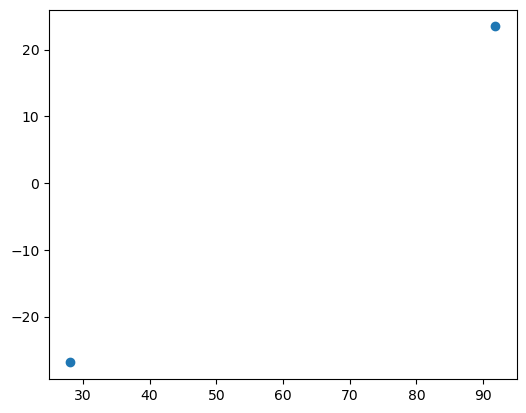

In [8]:
import geopandas as gpd
from pathlib import Path

# read the bounding box of the study area
val_pts = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('../data/validation-locations/subset-validation-reservoirs-grand.geojson'))

selected_reservoirs = [
    '0505', # dumboor. India
    # '0810', # sirindhorn, Thailand.
    # '0830', # Krasoew, Thailand.
    # '0502', # Bhakra dam, India.
    # '0518', # Bhadra, India.
    '0349', # vaaldam, South Africa.
    # '0464', # Sterkspruit, South Africa.
    # '0214', # Cijara, Spain
    # '1498', # Toledo bend, US
    # '0936', # Arrow, Canada
]

val_res_pt = val_pts.loc[val_pts['tmsos_id'].isin(selected_reservoirs)]
val_res_poly = val_polys.loc[val_polys['tmsos_id'].isin(selected_reservoirs)]

val_res_pt.plot()

In [9]:
import dask
from dask.distributed import Client

In [10]:
client = Client(
    n_workers=10, threads_per_worker=1
)
client

/tiger1/pdas47/tmsosPP/.env/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37967 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37967/status,
Dashboard: http://127.0.0.1:37967/status,Workers: 10
Total threads: 10,Total memory: 187.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38015,Workers: 10
Dashboard: http://127.0.0.1:37967/status,Total threads: 10
Started: Just now,Total memory: 187.55 GiB
Comm: tcp://127.0.0.1:43045,Total threads: 1
Dashboard: http://127.0.0.1:39135/status,Memory: 18.76 GiB
Nanny: tcp://127.0.0.1:42479,


In [11]:
import easysnowdata
import xarray as xr

def get_hls_id(
        id, 
        start_date="2022-07-01", 
        end_date="2022-07-31", 
        buffer=0.05
    ):
    roi = val_res_poly.loc[val_res_poly['tmsos_id']==id]
    buffered_roi = roi.geometry.iloc[0].convex_hull.buffer(buffer)
    hls = easysnowdata.remote_sensing.HLS(
        bbox_input=buffered_roi, start_date=start_date, end_date=end_date,
        bands=[
            'blue', 'green', 'red', 'nir narrow', 'swir 1', 'swir 2', 'Fmask'
        ]
    )
    hls.mask_data()

    raw_bands = hls.data
    hls.get_ndwi()
    ndwi = hls.ndwi.to_dataset(name='ndwi')

    data = xr.merge([raw_bands, ndwi])

    data = data.assign_coords(
        reservoir=((id))
    )

    data = data.chunk(chunks={
        'time': 30,
        'x': 4096,
        'y': 4096
    })
    
    # data['geometry'] = data['geometry'].astype(str)
    # data['AssociatedBrowseImageUrls'] = data['AssociatedBrowseImageUrls'].astype(str)

    return data

### serially download and save the data (skip to save time)
# dsses = []
# for id in selected_reservoirs:
#     ds = get_hls_id(id=id, start_date='2019-01-01', end_date='2020-12-31')
#     dsses.append(ds)

# dsses[1]
### save (skip to save time)
# remote_dsses = dsses.copy()
# for ds in tqdm(dsses):
#     reservoir_id = ds.reservoir.values
#     savefp = hls_save_dir / f'{reservoir_id}.zarr'

#     # temporarily remove geometry and AssociatedBrowseImageUrls
#     ds = ds.drop_vars(['geometry', 'AssociatedBrowseImageUrls'])

#     ds.to_zarr(savefp, mode='w', consolidated=True)

Read locally.

In [136]:
from shapely.geometry import mapping

def get_hls_area(ds, reservoir_id, save_dir=None):
    res_id = reservoir_id

    res_poly = val_res_poly[val_res_poly['tmsos_id']==ds.reservoir.values]

    res_poly_buffered = res_poly.copy()
    res_poly_buffered['geometry'] = res_poly.buffer(0.05)

    water_map = ds['ndwi'] > -0.3

    water_map = water_map.dropna(dim='time')

    water_map.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
    water_map.rio.write_crs(f"epsg:{water_map.spatial_ref.values}", inplace=True)

    water_map_area = water_map.sum(dim=['x', 'y']) * 1e2 * 1e-6
    
    # clipped = water_map.rio.clip(res_poly.geometry.apply(mapping), res_poly.crs, drop=True)

    df = water_map_area.to_dataframe().rename({"ndwi": "hls area [km2]"}, axis=1).reset_index().drop(['spatial_ref', 'eo:cloud_cover_avg'], axis=1)

    if save_dir is not None:
        save_dir = Path('../data/area/hls')
        save_dir.mkdir(exist_ok=True)

        save_fp = save_dir / f'{res_id}.csv'

        df.to_csv(save_fp, index=False)

    return df

In [137]:
selected_reservoirs

['0505', '0349']

In [138]:
# load
dsses = []
for reservoir_id in selected_reservoirs:
    print(reservoir_id)

    savefp = hls_save_dir / f'{reservoir_id}.zarr'
    ds = xr.open_zarr(savefp)
    area = get_hls_area(ds, reservoir_id, save_dir=Path('/tiger1/pdas47/tmsosPP/data/area/hls'))
    print(area)

    dsses.append(ds)
dsses

0505


/tmp/ipykernel_67100/1457010105.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  res_poly_buffered['geometry'] = res_poly.buffer(0.05)


                       time     platform reservoir  hls area [km2]
0   2019-01-02 04:41:48.360  Sentinel-2A      0505          5.4166
1   2019-01-04 04:31:57.140  Sentinel-2B      0505          5.1878
2   2019-01-07 04:41:52.710  Sentinel-2B      0505          5.4279
3   2019-01-09 04:31:54.330  Sentinel-2A      0505          5.1634
4   2019-01-12 04:41:49.830  Sentinel-2A      0505          5.4298
..                      ...          ...       ...             ...
272 2020-12-19 04:31:57.356  Sentinel-2A      0505          3.0289
273 2020-12-20 04:18:34.616    Landsat-8      0505          4.3530
274 2020-12-22 04:41:53.045  Sentinel-2A      0505          3.5387
275 2020-12-24 04:31:56.033  Sentinel-2B      0505          0.9863
276 2020-12-27 04:41:51.737  Sentinel-2B      0505          3.5988

[277 rows x 4 columns]
0349


/tmp/ipykernel_67100/1457010105.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  res_poly_buffered['geometry'] = res_poly.buffer(0.05)


                       time     platform reservoir  hls area [km2]
0   2019-01-02 08:17:30.510  Sentinel-2A      0349          0.0020
1   2019-01-07 08:17:34.890  Sentinel-2B      0349          0.7864
2   2019-01-12 08:17:31.980  Sentinel-2A      0349         30.2180
3   2019-01-14 08:02:10.009    Landsat-8      0349         30.5249
4   2019-01-17 08:17:36.000  Sentinel-2B      0349         30.7325
..                      ...          ...       ...             ...
177 2020-12-12 08:17:33.117  Sentinel-2A      0349          0.4802
178 2020-12-17 08:17:31.947  Sentinel-2B      0349          0.6892
179 2020-12-18 08:03:03.936    Landsat-8      0349          0.0000
180 2020-12-22 08:17:35.194  Sentinel-2A      0349          0.4030
181 2020-12-27 08:17:33.937  Sentinel-2B      0349         22.2872

[182 rows x 4 columns]


[<xarray.Dataset> Size: 4GB
 Dimensions:             (time: 277, y: 779, x: 650)
 Coordinates:
     eo:cloud_cover_avg  (time) int64 2kB dask.array<chunksize=(30,), meta=np.ndarray>
     platform            (time) <U11 12kB dask.array<chunksize=(30,), meta=np.ndarray>
     reservoir           <U4 16B ...
     spatial_ref         int32 4B ...
   * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
   * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
   * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
 Data variables:
     Fmask               (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
     blue                (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
     green               (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
     ndwi                (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), me

In [13]:
res1 = dsses[0]
res2 = dsses[1]

res1

<xarray.Dataset> Size: 4GB
Dimensions:             (time: 277, y: 779, x: 650)
Coordinates:
    eo:cloud_cover_avg  (time) int64 2kB dask.array<chunksize=(30,), meta=np.ndarray>
    platform            (time) <U11 12kB dask.array<chunksize=(30,), meta=np.ndarray>
    reservoir           <U4 16B ...
    spatial_ref         int32 4B ...
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
Data variables:
    Fmask               (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    blue                (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    green               (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    ndwi                (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    nir narrow          (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    red                 (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    swir 1              (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>
    swir 2              (time, y, x) float32 561MB dask.array<chunksize=(30, 779, 650), meta=np.ndarray>

In [16]:
res_poly = val_res_poly[val_res_poly['tmsos_id']==res1.reservoir.values]
res_poly

,GRAND_ID_left,RES_NAME_left,DAM_NAME_left,ALT_NAME_left,RIVER_left,ALT_RIVER_left,MAIN_BASIN_left,SUB_BASIN_left,NEAR_CITY_left,ALT_CITY_left,...,db,name,rid_id,grand_id,rid_filepath,resops_id,rid_filename,tmsos_id,distance,geometry
82,5121,None,Gumti,None,Gumti,None,Brahmaputra-Meghna,None,Amarpur,None,...,deltares,None,NaN,NaN,None,NaN,None,0505,NaN,"POLYGON ((91.82116 23.54628, 91.82196 23.54597..."


In [21]:
res_poly_buffered = res_poly.copy()
res_poly_buffered['geometry'] = res_poly.buffer(0.05)
res_poly_buffered

/tmp/ipykernel_67100/2709027352.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  res_poly_buffered['geometry'] = res_poly.buffer(0.05)


,GRAND_ID_left,RES_NAME_left,DAM_NAME_left,ALT_NAME_left,RIVER_left,ALT_RIVER_left,MAIN_BASIN_left,SUB_BASIN_left,NEAR_CITY_left,ALT_CITY_left,...,db,name,rid_id,grand_id,rid_filepath,resops_id,rid_filename,tmsos_id,distance,geometry
82,5121,None,Gumti,None,Gumti,None,Brahmaputra-Meghna,None,Amarpur,None,...,deltares,None,NaN,NaN,None,NaN,None,0505,NaN,"POLYGON ((91.76158 23.47984, 91.76068 23.48246..."


In [75]:
import hvplot.xarray

water_map = res1['ndwi'] > -0.3
water_map.hvplot(
    x='x', y='y', rasterize=True, geo=True, cmap='RdYlBu'
) * res_poly_buffered.hvplot(geo=True, color='white', alpha=0.2).opts(height=500, width=600)

BokehModel(combine_events=True, render_bundle={'docs_json': {'4e3de8bf-20c4-4157-82b5-65fd8c60f646': {'version…

In [76]:
water_map

<xarray.DataArray 'ndwi' (time: 277, y: 779, x: 650)> Size: 140MB
dask.array<gt, shape=(277, 779, 650), dtype=bool, chunksize=(30, 779, 650), chunktype=numpy.ndarray>
Coordinates:
    eo:cloud_cover_avg  (time) int64 2kB dask.array<chunksize=(30,), meta=np.ndarray>
    platform            (time) <U11 12kB dask.array<chunksize=(30,), meta=np.ndarray>
    reservoir           <U4 16B ...
    spatial_ref         int32 4B ...
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06

In [77]:
water_map = water_map.dropna(dim='time')

In [78]:
water_map.isel(time=0).hvplot(
    x='x', y='y', rasterize=True, geo=True, cmap='RdYlBu'
) * res_poly_buffered.hvplot(geo=True, color='white', alpha=0.2).opts(height=500, width=600)

BokehModel(combine_events=True, render_bundle={'docs_json': {'7f5b33d1-07c1-4ed2-8cfe-b84a6b9e008e': {'version…

In [79]:
water_map.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
water_map.rio.write_crs(f"epsg:{water_map.spatial_ref.values}", inplace=True)

<xarray.DataArray 'ndwi' (time: 277, y: 779, x: 650)> Size: 140MB
dask.array<getitem, shape=(277, 779, 650), dtype=bool, chunksize=(30, 779, 650), chunktype=numpy.ndarray>
Coordinates:
    eo:cloud_cover_avg  (time) int64 2kB dask.array<chunksize=(30,), meta=np.ndarray>
    platform            (time) <U11 12kB dask.array<chunksize=(30,), meta=np.ndarray>
    reservoir           <U4 16B ...
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
  * x                   (x) float64 5kB 3.732e+05 3.732e+05 ... 3.926e+05
  * y                   (y) float64 6kB 2.61e+06 2.61e+06 ... 2.587e+06
    spatial_ref         int64 8B 0

In [80]:
from shapely.geometry import mapping

clipped = water_map.rio.clip(res_poly.geometry.apply(mapping), res_poly.crs, drop=True)
clipped
# .hvplot(
#     x='x', y='y', rasterize=True, geo=True, cmap='RdYlBu'
# ) * res_poly_buffered.hvplot(geo=True, color='white', alpha=0.2).opts(height=500, width=600)

<xarray.DataArray 'ndwi' (time: 277, y: 405, x: 301)> Size: 34MB
dask.array<astype, shape=(277, 405, 301), dtype=bool, chunksize=(30, 405, 301), chunktype=numpy.ndarray>
Coordinates:
    eo:cloud_cover_avg  (time) int64 2kB dask.array<chunksize=(30,), meta=np.ndarray>
    platform            (time) <U11 12kB dask.array<chunksize=(30,), meta=np.ndarray>
    reservoir           <U4 16B ...
  * time                (time) datetime64[ns] 2kB 2019-01-02T04:41:48.360000 ...
  * x                   (x) float64 2kB 3.784e+05 3.784e+05 ... 3.874e+05
  * y                   (y) float64 3kB 2.605e+06 2.605e+06 ... 2.593e+06
    spatial_ref         int64 8B 0

In [81]:
clipped.isel(time=0).hvplot(
    x='x', y='y', rasterize=True, geo=True, cmap='RdYlBu'
) * res_poly_buffered.hvplot(geo=True, color='white', alpha=0.2).opts(height=500, width=600)

BokehModel(combine_events=True, render_bundle={'docs_json': {'3e0b2cab-54a9-4eac-8e74-6aae0cf823c6': {'version…

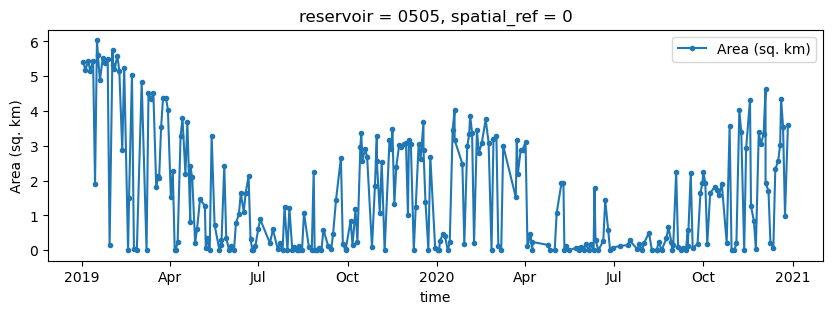

In [93]:
f = plt.figure(figsize=(10, 3))

water_map_area = water_map.sum(dim=['x', 'y']) * 1e2 * 1e-6

(water_map_area).plot(label='Area (sq. km)', marker='.')
plt.ylabel('Area (sq. km)')
plt.legend()

In [100]:
water_map_area = water_map.sum(dim=['x', 'y']) * 1e2 * 1e-6

df = water_map_area.to_dataframe().rename({"ndwi": "hls area [km2]"}, axis=1).reset_index().drop(['spatial_ref', 'eo:cloud_cover_avg'], axis=1)
df

,time,platform,reservoir,hls area [km2]
0,2019-01-02 04:41:48.360,Sentinel-2A,0505,5.4166
1,2019-01-04 04:31:57.140,Sentinel-2B,0505,5.1878
2,2019-01-07 04:41:52.710,Sentinel-2B,0505,5.4279
3,2019-01-09 04:31:54.330,Sentinel-2A,0505,5.1634
4,2019-01-12 04:41:49.830,Sentinel-2A,0505,5.4298
...,...,...,...,...
272,2020-12-19 04:31:57.356,Sentinel-2A,0505,3.0289
273,2020-12-20 04:18:34.616,Landsat-8,0505,4.3530
274,2020-12-22 04:41:53.045,Sentinel-2A,0505,3.5387
275,2020-12-24 04:31:56.033,Sentinel-2B,0505,0.9863


In [101]:
save_dir = Path('../data/area/hls')
save_dir.mkdir(exist_ok=True)

save_fp = save_dir / f'{res_id}.csv'

df.to_csv(save_fp, index=False)

df

,time,platform,reservoir,hls area [km2]
0,2019-01-02 04:41:48.360,Sentinel-2A,0505,5.4166
1,2019-01-04 04:31:57.140,Sentinel-2B,0505,5.1878
2,2019-01-07 04:41:52.710,Sentinel-2B,0505,5.4279
3,2019-01-09 04:31:54.330,Sentinel-2A,0505,5.1634
4,2019-01-12 04:41:49.830,Sentinel-2A,0505,5.4298
...,...,...,...,...
272,2020-12-19 04:31:57.356,Sentinel-2A,0505,3.0289
273,2020-12-20 04:18:34.616,Landsat-8,0505,4.3530
274,2020-12-22 04:41:53.045,Sentinel-2A,0505,3.5387
275,2020-12-24 04:31:56.033,Sentinel-2B,0505,0.9863


In [92]:
water_map.hvplot(
    x='x', y='y', rasterize=True, geo=True, cmap='RdYlBu', groupby='time'
) * res_poly_buffered.hvplot(geo=True, color='white', alpha=0.2).opts(height=500, width=600)

BokehModel(combine_events=True, render_bundle={'docs_json': {'bc67198b-0090-4b72-814a-a96ed47583a7': {'version…

In [56]:
def calc_area_hls(water_map, aoi):
    water_map = water_map.rio.clip(aoi)

    return water_map


In [60]:
calc_area_hls(water_map.isel(time=(0, 10)), res_poly_buffered.geometry.iloc[0])

TypeError: Variable None: Could not convert tuple of form (dims, data[, attrs, encoding]): (0, 10) to Variable.

# Sentinel-2

In [14]:
ds_fps = Path(f'../data/s2/{res_id}').glob('*.nc')

ds = xr.open_mfdataset(ds_fps)
ds

<xarray.Dataset> Size: 728MB
Dimensions:      (y: 2336, x: 1948, time: 10, band: 4, reservoir: 1)
Coordinates:
  * y            (y) float64 19kB 2.61e+06 2.61e+06 ... 2.587e+06 2.587e+06
  * x            (x) float64 16kB 3.732e+05 3.732e+05 ... 3.926e+05 3.926e+05
  * time         (time) datetime64[ns] 80B 2019-01-02T04:31:51.024000 ... 201...
  * band         (band) <U3 48B 'B04' 'B03' 'B02' 'B08'
  * reservoir    (reservoir) <U4 16B '0505'
    spatial_ref  int64 8B 0
Data variables:
    s2           (reservoir, band, time, y, x) float32 728MB dask.array<chunksize=(1, 4, 1, 2336, 1948), meta=np.ndarray>

In [15]:
def calc_ndwi(da):
    """
    Calculate the Normalized Difference Water Index (NDWI)
    """
    green = da.sel(band="B03")
    nir = da.sel(band="B08")
    return (green - nir) / (green + nir)

ndwi = calc_ndwi(ds['s2'])
ndwi

<xarray.DataArray 's2' (reservoir: 1, time: 10, y: 2336, x: 1948)> Size: 182MB
dask.array<truediv, shape=(1, 10, 2336, 1948), dtype=float32, chunksize=(1, 1, 2336, 1948), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 19kB 2.61e+06 2.61e+06 ... 2.587e+06 2.587e+06
  * x            (x) float64 16kB 3.732e+05 3.732e+05 ... 3.926e+05 3.926e+05
  * time         (time) datetime64[ns] 80B 2019-01-02T04:31:51.024000 ... 201...
  * reservoir    (reservoir) <U4 16B '0505'
    spatial_ref  int64 8B 0

In [16]:
ndwi.hvplot(x='x', y='y', rasterize=True, cmap='RdYlBu', clim=(-1, 0.3), width=800, height=600, title='NDWI')

BokehModel(combine_events=True, render_bundle={'docs_json': {'2c66e50d-f2f9-497e-a7f7-a7c628b13cfd': {'version…

In [17]:
ndwi.rio.crs.data['init'].split(':')[-1]

'32646'

In [18]:
dumboor_poly_projected = dumboor_poly.to_crs(ndwi.rio.crs.data['init'])
dumboor_poly_projected_buffered = dumboor_poly_projected.copy()
dumboor_poly_projected_buffered['geometry'] = dumboor_poly_projected.convex_hull.buffer(2000)
dumboor_poly_projected_buffered

,GRAND_ID_left,RES_NAME_left,DAM_NAME_left,ALT_NAME_left,RIVER_left,ALT_RIVER_left,MAIN_BASIN_left,SUB_BASIN_left,NEAR_CITY_left,ALT_CITY_left,...,db,name,rid_id,grand_id,rid_filepath,resops_id,rid_filename,tmsos_id,distance,geometry
82,5121,None,Gumti,None,Gumti,None,Brahmaputra-Meghna,None,Amarpur,None,...,deltares,None,NaN,NaN,None,NaN,None,0505,NaN,"POLYGON ((386807.402 2591115.275, 386653.432 2..."


In [19]:
water_map = ndwi > 0
water_map.hvplot(x='x', y='y', rasterize=True, cmap='Blues', clim=(0, 1), width=500, height=400, title='Water Map', crs=ndwi.rio.crs.data['init'].split(':')[-1]) + \
ndwi.hvplot(x='x', y='y', rasterize=True, cmap='RdYlBu', clim=(-1, 0.3), width=500, height=400, title='NDWI', crs=ndwi.rio.crs.data['init'].split(':')[-1]) * \
dumboor_poly_projected_buffered.hvplot(geo=True, tiles='OSM', alpha=0.5, crs=ndwi.rio.crs.data['init'].split(':')[-1])

BokehModel(combine_events=True, render_bundle={'docs_json': {'329a9d6a-03e6-4a90-8542-86c6bb70486c': {'version…

In [20]:
?water_map.rio.clip

Signature:
water_map.rio.clip(
    geometries: collections.abc.Iterable,
    crs: Optional[Any] = None,
    all_touched: bool = False,
    drop: bool = True,
    invert: bool = False,
    from_disk: bool = False,
) -> xarray.core.dataarray.DataArray
Docstring:
Crops a :obj:`xarray.DataArray` by geojson like geometry dicts.

Powered by `rasterio.features.geometry_mask`.

Examples:

    >>> geometry = ''' {"type": "Polygon",
    ...                 "coordinates": [
    ...                 [[-94.07955380199459, 41.69085871273774],
    ...                 [-94.06082436942204, 41.69103313774798],
    ...                 [-94.06063203899649, 41.67932439500822],
    ...                 [-94.07935807746362, 41.679150041277325],
    ...                 [-94.07955380199459, 41.69085871273774]]]}'''
    >>> cropping_geometries = [geojson.loads(geometry)]
    >>> xds = xarray.open_rasterio('cool_raster.tif')
    >>> cropped = xds.rio.clip(geometries=cropping_geometries, crs=4326)


.. versionadded

In [21]:
ndwi_clipped = ndwi.rio.clip(dumboor_poly_projected.geometry.apply(lambda x: x.buffer(2000)))
water_map_clipped = water_map.rio.clip(dumboor_poly_projected.geometry.apply(lambda x: x.buffer(2000)))
# ndwi_clipped.hvplot(x='x', y='y', rasterize=True, cmap='RdYlBu', clim=(-1, 0.3), width=800, height=600, title='NDWI')
water_map_clipped.hvplot(x='x', y='y', rasterize=True, cmap='RdYlBu', clim=(-1, 0.3), width=800, height=600, title='NDWI')

BokehModel(combine_events=True, render_bundle={'docs_json': {'f7f309be-fdce-4ad5-999e-a51eb08f76fc': {'version…

In [22]:
save_dir = Path('../data/area/s2')
save_dir.mkdir(exist_ok=True)

save_fp = save_dir / f'{res_id}.csv'

area = (water_map.sum(dim=['x', 'y']) * 1e2 * 1e-6) # km2
area_df = area.to_dataframe(name='s2 area [km2]').reset_index().drop('spatial_ref', axis=1)

# area_df.to_csv(save_fp, index=False)
area_df

,reservoir,time,s2 area [km2]
0,0505,2019-01-02 04:31:51.024,48.9612
1,0505,2019-01-04 04:21:49.024,47.4636
2,0505,2019-01-07 04:31:49.024,48.7878
3,0505,2019-01-09 04:21:41.024,48.6461
4,0505,2019-01-12 04:31:41.024,47.9296
5,0505,2019-01-17 04:31:19.024,47.7319
6,0505,2019-01-19 04:21:11.024,44.9288
7,0505,2019-01-22 04:31:01.024,47.1173
8,0505,2019-01-24 04:20:49.024,46.6986
9,0505,2019-01-27 04:30:39.024,47.5764


## temp otsu threshold

In [53]:
import numpy as np

def otsu_intraclass_variance(image, threshold):
    """
    Otsu's intra-class variance.
    If all pixels are above or below the threshold, this will throw a warning that can safely be ignored.
    """
    return np.nansum(
        [
            np.mean(cls) * np.var(image, where=cls)
            #   weight   ·  intra-class variance
            for cls in [image >= threshold, image < threshold]
        ]
    )
    # NaNs only arise if the class is empty, in which case the contribution should be zero, which `nansum` accomplishes.

# image = np.nan_to_num(ndwi.values, -1)
image = ndwi.values

otsu_threshold = min(
    np.linspace(-1, 1, 20),
    key=lambda th: otsu_intraclass_variance(image, th),
)

# val = filters.threshold_otsu(ndwi.values)
# otsu_threshold

In [54]:
otsu_threshold

-0.1578947368421053